In [ ]:
# https://dacon.io/en/codeshare/1803

In [1]:
!git clone https://github.com/e9t/nsmc.git
!pip install tensorflow_addons
!pip install torch>=1.8.1
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install sentencepiece
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
!pip install transformers

fatal: destination path 'nsmc' already exists and is not an empty directory.
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-_8qb067l/kobert-tokenizer_5dc2fd623ca944e195669068bdf32d84
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-_8qb067l/kobert-tokenizer_5dc2fd623ca944e195669068bdf32d84
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

TPU = False
if TPU:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
else:
  pass

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
from kobert_tokenizer import KoBERTTokenizer
import gluonnlp as nlp
from transformers import pipeline, AutoTokenizer, BertTokenizer, BertTokenizerFast
from transformers import AutoModel, BertModel, TFBertModel, TFBertForSequenceClassification
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 하이퍼파라미터
device = torch.device("cuda:0")
max_len = 64
batch_size = 32
epoch = 100
learning_rate =  5e-5
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 200
modelsave_location = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'Research',
                                  'Colab', 'Model', 'modeling_KoBERT_20231018.pt')
predfile_location = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'Research',
                                  'Colab', 'Data', 'df_news.csv')

class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

class BERTDataset():
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

/usr/local/lib/python3.10/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-4-df05b748e1dc>:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.903955340385437 train acc 0.03125
epoch 1 train acc 0.40386146496815284


<ipython-input-4-df05b748e1dc>:79: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 1 test acc 0.4898487261146497


<ipython-input-4-df05b748e1dc>:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9122887849807739 train acc 0.65625
epoch 2 train acc 0.6013136942675159


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 2 test acc 0.7880175159235668


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.5796977281570435 train acc 0.78125
epoch 3 train acc 0.8126990445859873


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 3 test acc 0.8184713375796179


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.48003697395324707 train acc 0.8125
epoch 4 train acc 0.879578025477707


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 4 test acc 0.8258359872611465


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.36919263005256653 train acc 0.84375
epoch 5 train acc 0.9221735668789809


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 5 test acc 0.8304140127388535


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.16665619611740112 train acc 0.90625
epoch 6 train acc 0.9257563694267515


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 6 test acc 0.8202627388535032


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.13018904626369476 train acc 0.9375
epoch 7 train acc 0.9390923566878981


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 7 test acc 0.8258359872611465


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.17964334785938263 train acc 0.9375
epoch 8 train acc 0.9476512738853503


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 8 test acc 0.8316082802547771


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.07302135229110718 train acc 0.96875
epoch 9 train acc 0.960390127388535


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 9 test acc 0.8228503184713376


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.12273743748664856 train acc 0.9375
epoch 10 train acc 0.9711385350318471


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 10 test acc 0.8258359872611465


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.009903328493237495 train acc 1.0
epoch 11 train acc 0.9761146496815286


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 11 test acc 0.8228503184713376


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.24213416874408722 train acc 0.9375
epoch 12 train acc 0.9802945859872612


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 12 test acc 0.7585589171974523


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.7084136009216309 train acc 0.875
epoch 13 train acc 0.9737261146496815


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 13 test acc 0.8196656050955414


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.07899092137813568 train acc 0.96875
epoch 14 train acc 0.98328025477707


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 14 test acc 0.8369824840764332


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.019860824570059776 train acc 1.0
epoch 15 train acc 0.9890525477707006


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 15 test acc 0.8164808917197452


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.17928458750247955 train acc 0.96875
epoch 16 train acc 0.9830812101910829


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 16 test acc 0.8264331210191083


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.0009663982200436294 train acc 1.0
epoch 17 train acc 0.987062101910828


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 17 test acc 0.8333996815286624


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.0009850163478404284 train acc 1.0
epoch 18 train acc 0.9884554140127388


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 18 test acc 0.830812101910828


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.004854516591876745 train acc 1.0
epoch 19 train acc 0.9868630573248408


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 19 test acc 0.8421576433121019


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.0012143263593316078 train acc 1.0
epoch 20 train acc 0.9884554140127388


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 20 test acc 0.8326035031847133


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.035306625068187714 train acc 0.96875
epoch 21 train acc 0.9918391719745223


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 21 test acc 0.8194665605095541


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.0007092443993315101 train acc 1.0
epoch 22 train acc 0.9920382165605095


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 22 test acc 0.8318073248407644


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.003290739143267274 train acc 1.0
epoch 23 train acc 0.9918391719745223


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 23 test acc 0.8326035031847133


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.0006223364034667611 train acc 1.0
epoch 24 train acc 0.990047770700637


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 24 test acc 0.834593949044586


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.0003950372920371592 train acc 1.0
epoch 25 train acc 0.9928343949044586


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 25 test acc 0.830812101910828


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.000863288005348295 train acc 1.0
epoch 26 train acc 0.9942277070063694


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 26 test acc 0.8383757961783439


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 0.0008463726844638586 train acc 1.0
epoch 27 train acc 0.9956210191082803


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 27 test acc 0.8326035031847133


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.0006088105728849769 train acc 1.0
epoch 28 train acc 0.9960191082802548


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 28 test acc 0.8381767515923567


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.0011472676414996386 train acc 1.0
epoch 29 train acc 0.9930334394904459


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 29 test acc 0.8284235668789809


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.0002854802878573537 train acc 1.0
epoch 30 train acc 0.9944267515923567


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 30 test acc 0.8375796178343949


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 31 batch id 1 loss 0.0003094744752161205 train acc 1.0
epoch 31 train acc 0.9944267515923567


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 31 test acc 0.8365843949044586


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 32 batch id 1 loss 0.0002706741215661168 train acc 1.0
epoch 32 train acc 0.9918391719745223


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 32 test acc 0.8252388535031847


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 33 batch id 1 loss 0.10122208297252655 train acc 0.96875
epoch 33 train acc 0.9944267515923567


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 33 test acc 0.8296178343949044


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 34 batch id 1 loss 0.00018642062786966562 train acc 1.0
epoch 34 train acc 0.9930334394904459


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 34 test acc 0.8322054140127388


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 35 batch id 1 loss 0.00041625931044109166 train acc 1.0
epoch 35 train acc 0.9928343949044586


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 35 test acc 0.8304140127388535


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 36 batch id 1 loss 0.00022917376190889627 train acc 1.0
epoch 36 train acc 0.9944267515923567


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 36 test acc 0.8369824840764332


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 37 batch id 1 loss 0.00024152400146704167 train acc 1.0
epoch 37 train acc 0.9932324840764332


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 37 test acc 0.8333996815286624


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 38 batch id 1 loss 0.00017760973423719406 train acc 1.0
epoch 38 train acc 0.9966162420382165


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 38 test acc 0.8369824840764332


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 39 batch id 1 loss 0.00017701939214020967 train acc 1.0
epoch 39 train acc 0.996218152866242


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 39 test acc 0.8286226114649682


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 40 batch id 1 loss 0.00111875229049474 train acc 1.0
epoch 40 train acc 0.996218152866242


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 40 test acc 0.8260350318471338


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 41 batch id 1 loss 0.0001202698695124127 train acc 1.0
epoch 41 train acc 0.9956210191082803


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 41 test acc 0.8322054140127388


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 42 batch id 1 loss 0.00011939041723962873 train acc 1.0
epoch 42 train acc 0.9972133757961783


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 42 test acc 0.8282245222929936


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 43 batch id 1 loss 0.0008040780085138977 train acc 1.0
epoch 43 train acc 0.9968152866242038


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 43 test acc 0.8268312101910829


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 44 batch id 1 loss 0.0010717519326135516 train acc 1.0
epoch 44 train acc 0.9942277070063694


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 44 test acc 0.8180732484076433


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 45 batch id 1 loss 0.00018698190979193896 train acc 1.0
epoch 45 train acc 0.9936305732484076


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 45 test acc 0.8125


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 46 batch id 1 loss 0.0004893665318377316 train acc 1.0
epoch 46 train acc 0.9958200636942676


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 46 test acc 0.8326035031847133


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 47 batch id 1 loss 0.0001685408060438931 train acc 1.0
epoch 47 train acc 0.9976114649681529


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 47 test acc 0.8365843949044586


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 48 batch id 1 loss 7.690123311476782e-05 train acc 1.0
epoch 48 train acc 0.9974124203821656


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 48 test acc 0.8282245222929936


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 49 batch id 1 loss 8.00366178737022e-05 train acc 1.0
epoch 49 train acc 0.9972133757961783


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 49 test acc 0.8318073248407644


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 50 batch id 1 loss 0.00012732658069580793 train acc 1.0
epoch 50 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 50 test acc 0.8339968152866242


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 51 batch id 1 loss 5.185062036616728e-05 train acc 1.0
epoch 51 train acc 0.9980095541401274


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 51 test acc 0.8393710191082803


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 52 batch id 1 loss 0.00016697525279596448 train acc 1.0
epoch 52 train acc 0.9978105095541401


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 52 test acc 0.8280254777070064


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 53 batch id 1 loss 4.5484463043976575e-05 train acc 1.0
epoch 53 train acc 0.9980095541401274


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 53 test acc 0.8314092356687898


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 54 batch id 1 loss 3.882405144395307e-05 train acc 1.0
epoch 54 train acc 0.9960191082802548


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 54 test acc 0.8341958598726115


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 55 batch id 1 loss 0.0002318343031220138 train acc 1.0
epoch 55 train acc 0.9964171974522293


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 55 test acc 0.8316082802547771


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 56 batch id 1 loss 8.233930566348135e-05 train acc 1.0
epoch 56 train acc 0.9970143312101911


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 56 test acc 0.825437898089172


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 57 batch id 1 loss 6.771919288439676e-05 train acc 1.0
epoch 57 train acc 0.996218152866242


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 57 test acc 0.8397691082802548


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 58 batch id 1 loss 0.00014492945047095418 train acc 1.0
epoch 58 train acc 0.9972133757961783


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 58 test acc 0.835390127388535


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 59 batch id 1 loss 0.00011781261127907783 train acc 1.0
epoch 59 train acc 0.9968152866242038


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 59 test acc 0.8363853503184714


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 60 batch id 1 loss 7.643175194971263e-05 train acc 1.0
epoch 60 train acc 0.9960191082802548


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 60 test acc 0.8333996815286624


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 61 batch id 1 loss 0.00010143431427422911 train acc 1.0
epoch 61 train acc 0.9972133757961783


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 61 test acc 0.8316082802547771


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 62 batch id 1 loss 5.703450369765051e-05 train acc 1.0
epoch 62 train acc 0.9972133757961783


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 62 test acc 0.8383757961783439


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 63 batch id 1 loss 0.00013319293793756515 train acc 1.0
epoch 63 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 63 test acc 0.8373805732484076


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 64 batch id 1 loss 5.221529499976896e-05 train acc 1.0
epoch 64 train acc 0.9984076433121019


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 64 test acc 0.8413614649681529


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 65 batch id 1 loss 7.444107177434489e-05 train acc 1.0
epoch 65 train acc 0.9970143312101911


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 65 test acc 0.8379777070063694


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 66 batch id 1 loss 5.526612949324772e-05 train acc 1.0
epoch 66 train acc 0.9978105095541401


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 66 test acc 0.8389729299363057


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 67 batch id 1 loss 4.99358975503128e-05 train acc 1.0
epoch 67 train acc 0.9980095541401274


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 67 test acc 0.8385748407643312


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 68 batch id 1 loss 4.925014582113363e-05 train acc 1.0
epoch 68 train acc 0.9980095541401274


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 68 test acc 0.8369824840764332


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 69 batch id 1 loss 4.23926321673207e-05 train acc 1.0
epoch 69 train acc 0.9978105095541401


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 69 test acc 0.8405652866242038


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 70 batch id 1 loss 4.674352385336533e-05 train acc 1.0
epoch 70 train acc 0.9986066878980892


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 70 test acc 0.8403662420382165


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 71 batch id 1 loss 2.9153590730857104e-05 train acc 1.0
epoch 71 train acc 0.9978105095541401


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 71 test acc 0.8419585987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 72 batch id 1 loss 3.174255834892392e-05 train acc 1.0
epoch 72 train acc 0.9984076433121019


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 72 test acc 0.8361863057324841


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 73 batch id 1 loss 3.129175820504315e-05 train acc 1.0
epoch 73 train acc 0.9978105095541401


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 73 test acc 0.835390127388535


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 74 batch id 1 loss 2.95335084956605e-05 train acc 1.0
epoch 74 train acc 0.9976114649681529


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 74 test acc 0.8361863057324841


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 75 batch id 1 loss 2.713449975999538e-05 train acc 1.0
epoch 75 train acc 0.9976114649681529


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 75 test acc 0.835390127388535


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 76 batch id 1 loss 3.824471423286013e-05 train acc 1.0
epoch 76 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 76 test acc 0.8347929936305732


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 77 batch id 1 loss 2.9399358027148992e-05 train acc 1.0
epoch 77 train acc 0.9978105095541401


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 77 test acc 0.8355891719745223


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 78 batch id 1 loss 2.7086067348136567e-05 train acc 1.0
epoch 78 train acc 0.9978105095541401


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 78 test acc 0.835390127388535


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 79 batch id 1 loss 2.9175758754718117e-05 train acc 1.0
epoch 79 train acc 0.9984076433121019


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 79 test acc 0.8369824840764332


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 80 batch id 1 loss 2.972342372231651e-05 train acc 1.0
epoch 80 train acc 0.9986066878980892


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 80 test acc 0.8326035031847133


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 81 batch id 1 loss 2.492179373803083e-05 train acc 1.0
epoch 81 train acc 0.9986066878980892


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 81 test acc 0.833797770700637


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 82 batch id 1 loss 2.147602936020121e-05 train acc 1.0
epoch 82 train acc 0.9978105095541401


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 82 test acc 0.8349920382165605


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 83 batch id 1 loss 0.09755207598209381 train acc 0.96875
epoch 83 train acc 0.9978105095541401


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 83 test acc 0.8381767515923567


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 84 batch id 1 loss 2.001947541430127e-05 train acc 1.0
epoch 84 train acc 0.9984076433121019


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 84 test acc 0.8383757961783439


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 85 batch id 1 loss 2.399786353635136e-05 train acc 1.0
epoch 85 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 85 test acc 0.8393710191082803


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 86 batch id 1 loss 2.1028996343375184e-05 train acc 1.0
epoch 86 train acc 0.9980095541401274


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 86 test acc 0.8387738853503185


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 87 batch id 1 loss 2.1420117263915017e-05 train acc 1.0
epoch 87 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 87 test acc 0.839171974522293


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 88 batch id 1 loss 2.33348437177483e-05 train acc 1.0
epoch 88 train acc 0.9986066878980892


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 88 test acc 0.8375796178343949


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 89 batch id 1 loss 1.9482999050524086e-05 train acc 1.0
epoch 89 train acc 0.9990047770700637


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 89 test acc 0.8377786624203821


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 90 batch id 1 loss 2.2306654500425793e-05 train acc 1.0
epoch 90 train acc 0.9984076433121019


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 90 test acc 0.8375796178343949


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 91 batch id 1 loss 2.1394071154645644e-05 train acc 1.0
epoch 91 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 91 test acc 0.8375796178343949


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 92 batch id 1 loss 2.797261367959436e-05 train acc 1.0
epoch 92 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 92 test acc 0.8373805732484076


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 93 batch id 1 loss 2.087994471366983e-05 train acc 1.0
epoch 93 train acc 0.9992038216560509


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 93 test acc 0.8373805732484076


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 94 batch id 1 loss 2.142008816008456e-05 train acc 1.0
epoch 94 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 94 test acc 0.8373805732484076


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 95 batch id 1 loss 1.856288145063445e-05 train acc 1.0
epoch 95 train acc 0.9984076433121019


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 95 test acc 0.8373805732484076


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 96 batch id 1 loss 2.53874204645399e-05 train acc 1.0
epoch 96 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 96 test acc 0.8375796178343949


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 97 batch id 1 loss 1.9870438336511143e-05 train acc 1.0
epoch 97 train acc 0.9982085987261147


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 97 test acc 0.8375796178343949


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 98 batch id 1 loss 2.4701965230633505e-05 train acc 1.0
epoch 98 train acc 0.9984076433121019


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 98 test acc 0.8379777070063694


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 99 batch id 1 loss 2.320076964679174e-05 train acc 1.0
epoch 99 train acc 0.9984076433121019


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 99 test acc 0.8379777070063694


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 100 batch id 1 loss 2.3241735107148997e-05 train acc 1.0
epoch 100 train acc 0.9980095541401274


  0%|          | 0/157 [00:00<?, ?it/s]

epoch 100 test acc 0.8379777070063694


[0.03125,
 0.65625,
 0.78125,
 0.8125,
 0.84375,
 0.90625,
 0.9375,
 0.9375,
 0.96875,
 0.9375,
 1.0,
 0.9375,
 0.875,
 0.96875,
 1.0,
 0.96875,
 1.0,
 1.0,
 1.0,
 1.0,
 0.96875,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.96875,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.96875,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

[0.4898487261146497,
 0.7880175159235668,
 0.8184713375796179,
 0.8258359872611465,
 0.8304140127388535,
 0.8202627388535032,
 0.8258359872611465,
 0.8316082802547771,
 0.8228503184713376,
 0.8258359872611465,
 0.8228503184713376,
 0.7585589171974523,
 0.8196656050955414,
 0.8369824840764332,
 0.8164808917197452,
 0.8264331210191083,
 0.8333996815286624,
 0.830812101910828,
 0.8421576433121019,
 0.8326035031847133,
 0.8194665605095541,
 0.8318073248407644,
 0.8326035031847133,
 0.834593949044586,
 0.830812101910828,
 0.8383757961783439,
 0.8326035031847133,
 0.8381767515923567,
 0.8284235668789809,
 0.8375796178343949,
 0.8365843949044586,
 0.8252388535031847,
 0.8296178343949044,
 0.8322054140127388,
 0.8304140127388535,
 0.8369824840764332,
 0.8333996815286624,
 0.8369824840764332,
 0.8286226114649682,
 0.8260350318471338,
 0.8322054140127388,
 0.8282245222929936,
 0.8268312101910829,
 0.8180732484076433,
 0.8125,
 0.8326035031847133,
 0.8365843949044586,
 0.8282245222929936,
 0.8318

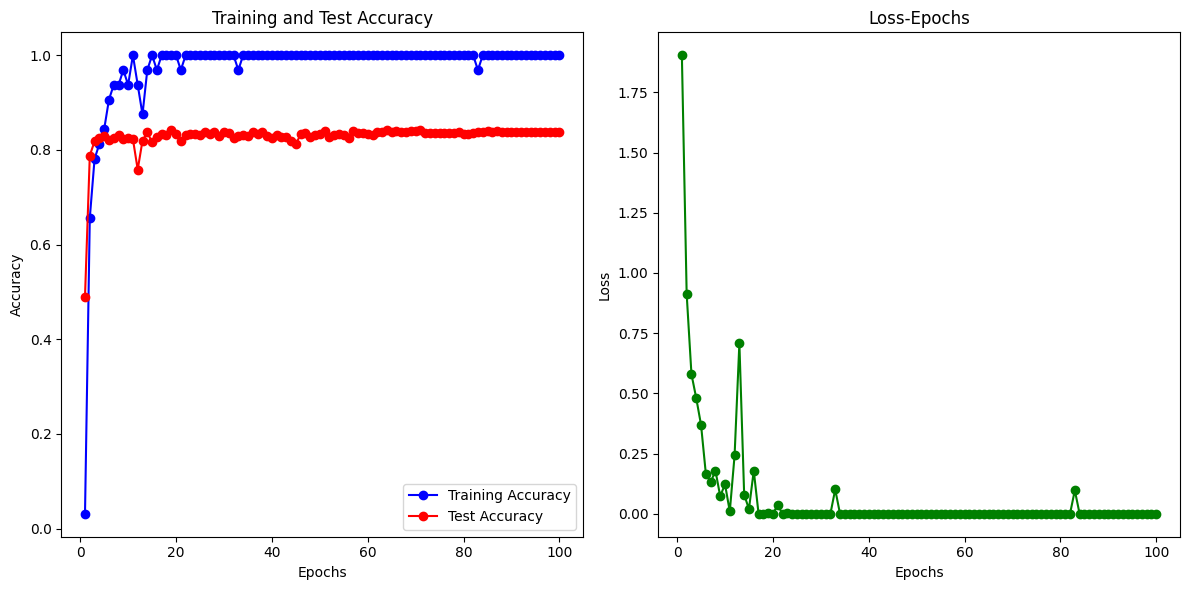

In [ ]:
# 데이터처리
train = pd.read_table("nsmc/"+"ratings_train.txt")
train = train.dropna().sample(5000).reset_index().iloc[:,1:].iloc[:,1:].values.tolist()
test = pd.read_table("nsmc/"+"ratings_test.txt")
test = test.dropna().sample(5000).reset_index().iloc[:,1:].iloc[:,1:].values.tolist()

tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)

data_train = BERTDataset(train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tokenizer, vocab, max_len, True, False)
train_dataloader = DataLoader(data_train, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(data_test, batch_size=batch_size, num_workers=2)

# 모델링세팅
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
loss_fn = nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

t_total = len(train_dataloader) * epoch
warmup_step = int(t_total * warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# 학습
train_history = []
test_history = []
loss_history = []

for e in range(epoch):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        # print(label.shape, out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    # train_history.append(train_acc / (batch_id+1))
    model.eval() # 모델을 평가 모드로 설정
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids) # 모델에 입력 데이터 전달하여 출력 얻기
        test_acc += calc_accuracy(out, label) # 정확도 계산하여 누적
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1)) # 테스트 정확도의 추이를 기록하고 후에 시각화하거나 분석하는 데 사용

# 모델저장
torch.save(model.state_dict(), modelsave_location)

# 시각화
epochs = range(1, epoch + 1)
display(train_history, test_history)
## training and test accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_history, 'bo-', label='Training Accuracy')
plt.plot(epochs, test_history, 'ro-', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
## training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_history, 'go-')
plt.title('Loss-Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()


In [ ]:
# 모델 및 예측데이터 로딩
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
model.load_state_dict(torch.load(modelsave_location))
df_news = pd.read_csv(predfile_location)
## 예측함수
def predict_sentiment(sentence):
    data = [sentence, '0']
    dataset = [data]
    test_data = BERTDataset(dataset, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=5)

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        predicted_index = out.argmax() + 1

    return predicted_index.item()
## 예측
tqdm.pandas()
# df_news_sentiment = df_news['제목'][:100000].progress_apply(predict_sentiment)
# predsave_location = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'Research',
#                                   'Colab', 'Data', 'df_news_sentiment1.csv')
# df_news_sentiment.to_csv(predsave_location)
for i in range(60000, 300000, 10000):
    df_news_sentiment = df_news['제목'][i:i+10000].progress_apply(predict_sentiment)
    predsave_location = os.path.join(os.getcwd(), 'gdrive', 'MyDrive', 'Research',
                                     'Colab', 'Data', 'df_news_sentiment'+str(i)+'.csv')
    df_news_sentiment.to_csv(predsave_location)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
 62%|██████▏   | 6220/10000 [31:12<20:26,  3.08it/s]

In [ ]:
# !git clone https://github.com/e9t/nsmc.git
train = pd.read_table("nsmc/"+"ratings_train.txt")
train = train.dropna().sample(5000).reset_index().iloc[:,1:]
test = pd.read_table("nsmc/"+"ratings_test.txt")
test = test.dropna().sample(5000).reset_index().iloc[:,1:]

data_train = BERTDataset(train, 0, 1, tokenizer, vocab, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tokenizer, vocab, max_len, True, False)


def preprocessing_sentence_to_BERTinput(df, tokenizer, colname_data, colname_target=None, seq_len=128,
                                        return_type='tensor'):
    tokens, masks, segments, targets = [], [], [], []
    for i in tqdm(range(len(df))):
        # 변환
        token = tokenizer.encode_plus(df[colname_data][i], max_length=seq_len,
                                      pad_to_max_length=True, truncation=True,
                                      return_attention_mask=True,
                                      add_special_tokens=True)

        # 정리
        tokens.append(token['input_ids'])
        masks.append(token['attention_mask'])
        segments.append(token['token_type_ids'])
        if colname_target != None:
            targets.append(df[colname_target][i])

    # array 변환
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    if colname_target != None:
        targets = np.array(targets)

    # tensor 변환
    if return_type == 'tensor':
        tokens = tf.convert_to_tensor(tokens, dtype=tf.int32)
        masks = tf.convert_to_tensor(masks, dtype=tf.int32)
        segments = tf.convert_to_tensor(segments, dtype=tf.int32)

    return [tokens, masks, segments], targets

import tensorflow_addons as tfa
from transformers import pipeline, AutoTokenizer, BertTokenizer, BertTokenizerFast
from transformers import AutoModel, AutoModelForTokenClassification, TFBertModel, TFBertForSequenceClassification

MODEL_NAME = 'monologg/kobert'    # 'bert-base-multilingual-cased', 'klue/roberta-base'
# OPTIMIZER = tfa.optimizers.RectifiedAdam(lr=1.0e-5, weight_decay=0.0025, warmup_proportion=0.05)
OPTIMIZER = tf.keras.optimizers.Adam(lr=1.0e-5)
NUM_LABELS = 2
SEQ_LEN = 64

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
X_train, Y_train = preprocessing_sentence_to_BERTinput(train, tokenizer=tokenizer,
                                                       colname_target='label', colname_data='document', seq_len=SEQ_LEN)
X_test, Y_test = preprocessing_sentence_to_BERTinput(test, tokenizer=tokenizer,
                                                       colname_target='label', colname_data='document', seq_len=SEQ_LEN)

def modeling_BERTsentiment(model_name, optimizer, num_labels=2, seq_len=128):
    # 모델 로딩
    model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=metric)

    return model

# def modeling_BERTsentiment(model_name, optimizer, num_labels=2, seq_len=128):
#     # 모델 로딩
#     model = TFBertModel.from_pretrained(model_name, num_labels=num_labels, output_hidden_states=True)
#     outputs = model([tokens, masks, segments])[1]

#     # 모델 구성
#     layer = tf.keras.layers.Dense(1, activation='sigmoid',
#                                   kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(outputs)
#     model_sentiment = tf.keras.Model([tokens, masks, segments], layer)
#     model_sentiment.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

#     return model_sentiment


model = modeling_BERTsentiment(model_name=MODEL_NAME, optimizer=OPTIMIZER, num_labels=NUM_LABELS, seq_len=SEQ_LEN)
model.fit(X_train, Y_train, epochs=10, shuffle=True, batch_size=100, validation_data=(X_test, Y_test))


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 5000/5000 [00:02<00:00, 1858.76it/s]


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
50/50 [==============================] - 338s 6s/step - loss: 0.7259 - accuracy: 0.4976 - val_loss: 0.6971 - val_accuracy: 0.5060
Epoch 2/10
50/50 [==============================] - 299s 6s/step - loss: 0.6959 - accuracy: 0.4974 - val_loss: 0.6934 - val_accuracy: 0.4940
Epoch 3/10
50/50 [==============================] - 299s 6s/step - loss: 0.6963 - accuracy: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.5060
Epoch 4/10
50/50 [==============================] - 299s 6s/step - loss: 0.6994 - accuracy: 0.5048 - val_loss: 0.7111 - val_accuracy: 0.4940
Epoch 5/10
50/50 [==============================] - 298s 6s/step - loss: 0.7031 - accuracy: 0.5008 - val_loss: 0.7033 - val_accuracy: 0.4940
Epoch 6/10
50/50 [==============================] - 299s 6s/step - loss: 0.6974 - accuracy: 0.5114 - val_loss: 0.7011 - val_accuracy: 0.4940
Epoch 7/10
50/50 [==============================] - 298s 6s/step - loss: 0.6980 - accuracy: 0.5060 - val_loss: 0.7077 - val_accuracy: 0.4940
Epoch 8/10
50